<a href="https://colab.research.google.com/github/thanusree02/ai-asstent-coding/blob/main/diabetes_detection_from_patient_data_using_decision_tree1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
`# Colab setup: install any extras (most are already installed)
!pip install -q scikit-learn pandas matplotlib seaborn joblib

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, precision_score, recall_score
)
import joblib
from google.colab import files


In [ ]:
# Upload a CSV file from your computer (use the file picker)
uploaded = files.upload()  # run this cell and pick the CSV file
# After upload, get filename:
filename = next(iter(uploaded))
df = pd.read_csv(filename)
print("Loaded", filename)
df.head()


Saving diabetes.csv to diabetes (1).csv
Loaded diabetes (1).csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Shape: (768, 9)
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000



Outcome counts:
 Outcome
0    500
1    268
Name: count, dtype: int64


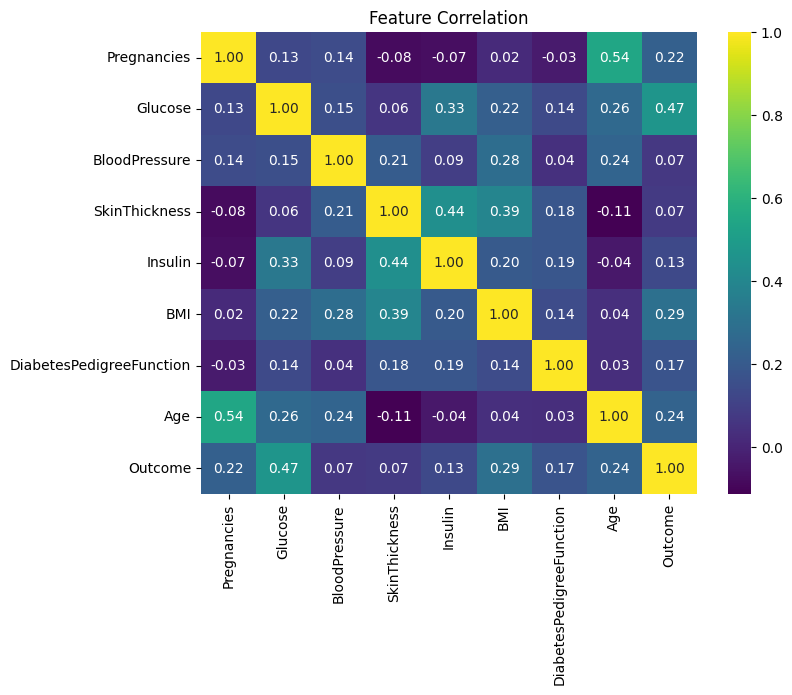

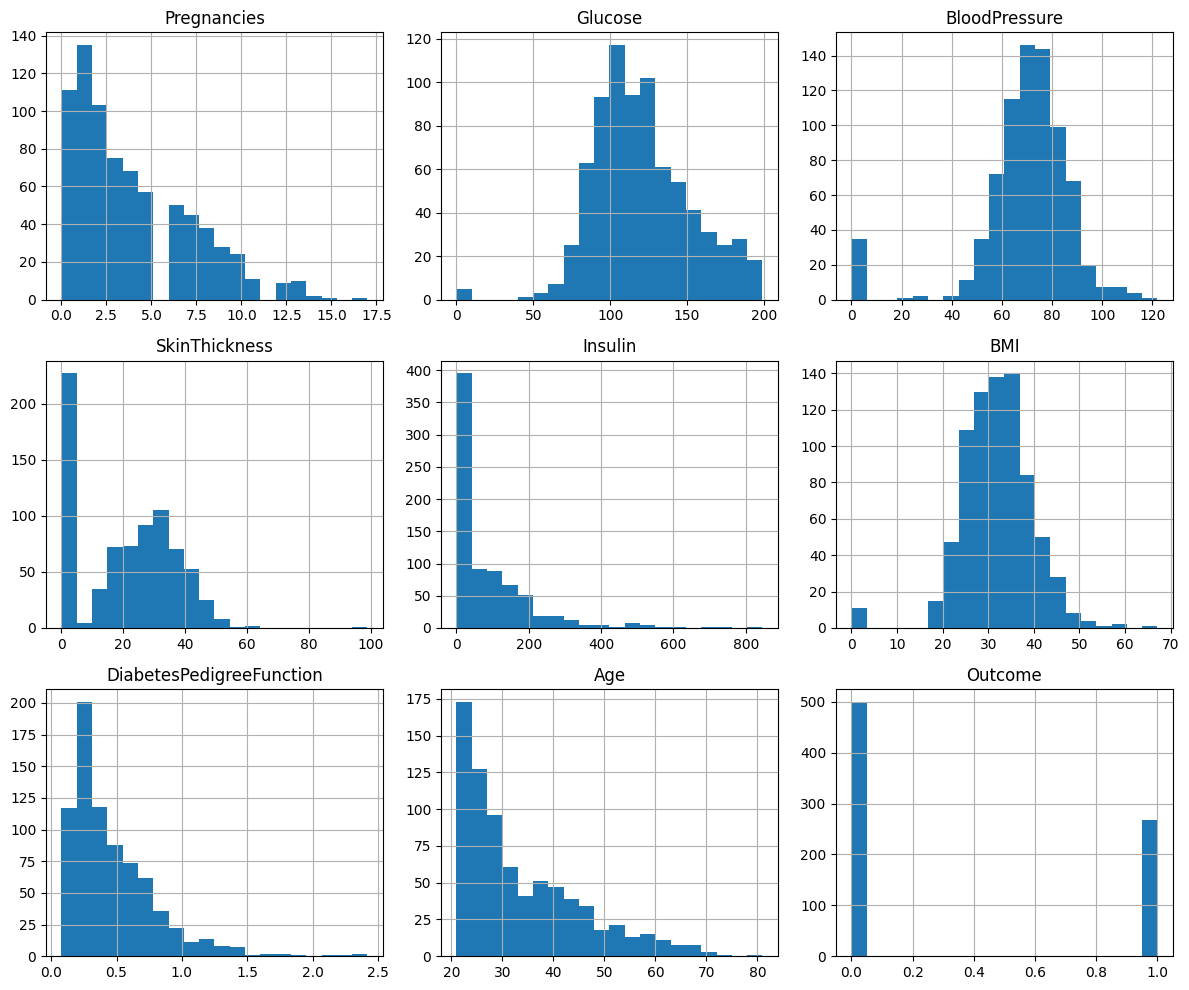

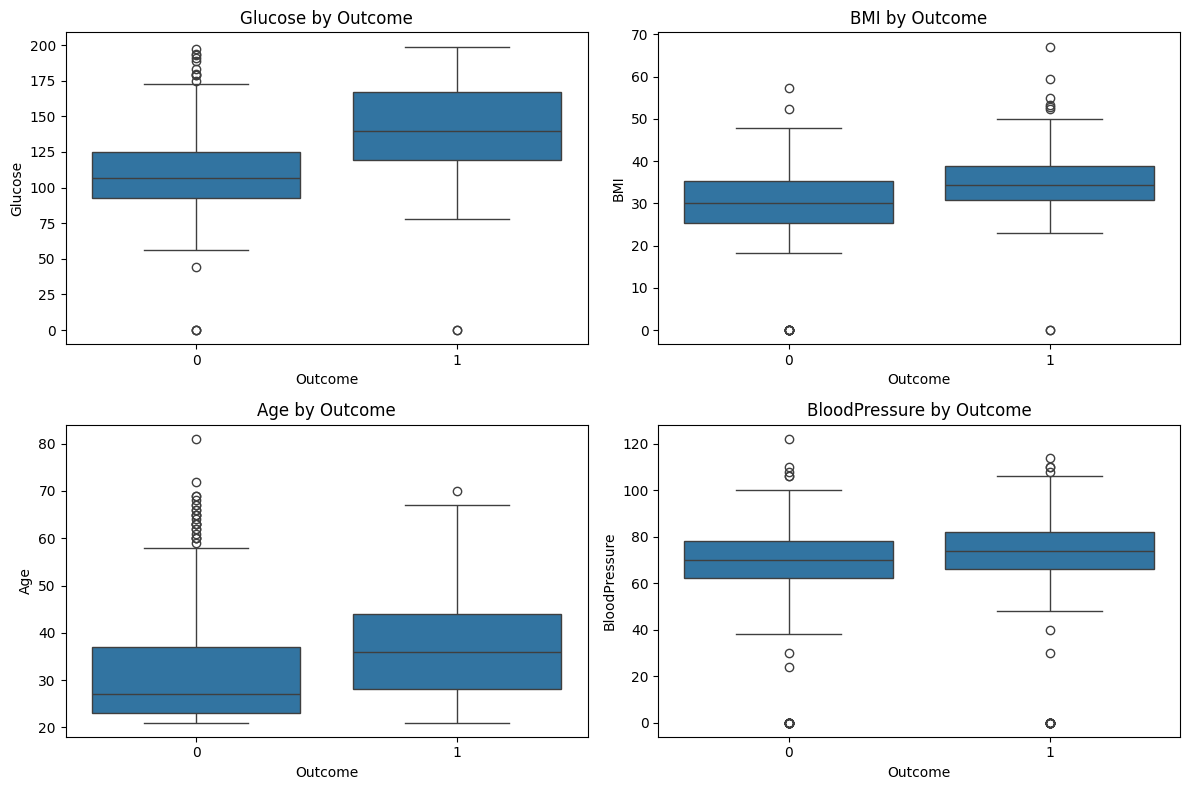

In [ ]:
# Basic info
print("Shape:", df.shape)
print(df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
display(df.describe())

# Check distribution of target
print("\nOutcome counts:\n", df['Outcome'].value_counts())

# Pairwise correlations heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title("Feature Correlation")
plt.show()

# Histograms
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

# Boxplots for some numeric features by Outcome
cols = ['Glucose','BMI','Age','BloodPressure']
plt.figure(figsize=(12,8))
for i, c in enumerate(cols,1):
    plt.subplot(2,2,i)
    sns.boxplot(x='Outcome', y=c, data=df)
    plt.title(c + " by Outcome")
plt.tight_layout()
plt.show()


In [ ]:
# Columns where 0 likely means missing
zero_as_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Replace zeros with NaN for these columns
df[zero_as_missing] = df[zero_as_missing].replace(0, np.nan)

# Show missing counts
print("Missing counts after replacement:\n", df.isnull().sum())

# Simple imputation: fill NaN with median (robust)
for col in zero_as_missing:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

print("Missing counts after imputation:\n", df.isnull().sum())

# Optional: feature and target split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Optionally scale features for some models (Decision Tree doesn't need it, but keep if you compare)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# We'll keep both X (original) and X_scaled; Decision Tree uses X


Missing counts after replacement:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Missing counts after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-1463655652.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [ ]:
# Use stratify to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


Accuracy: 0.6818181818181818
Precision: 0.5531914893617021
Recall: 0.48148148148148145
F1-score:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       100
           1       0.55      0.48      0.51        54

    accuracy                           0.68       154
   macro avg       0.65      0.64      0.64       154
weighted avg       0.67      0.68      0.68       154



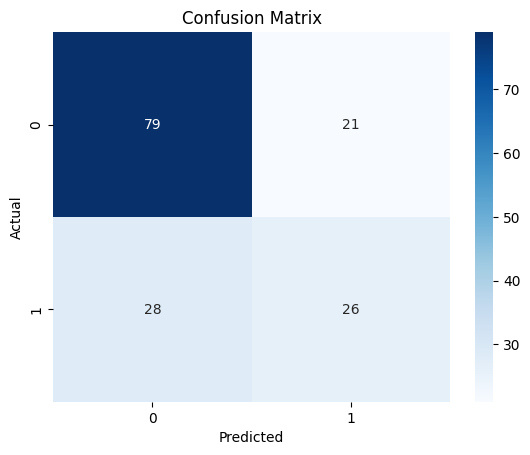

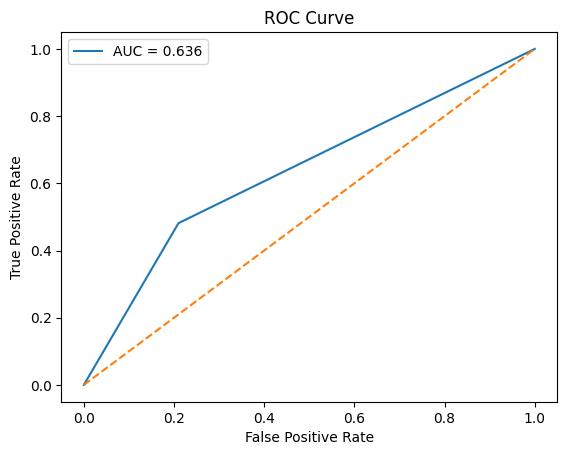

In [ ]:
# Baseline model (no tuning)
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:,1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


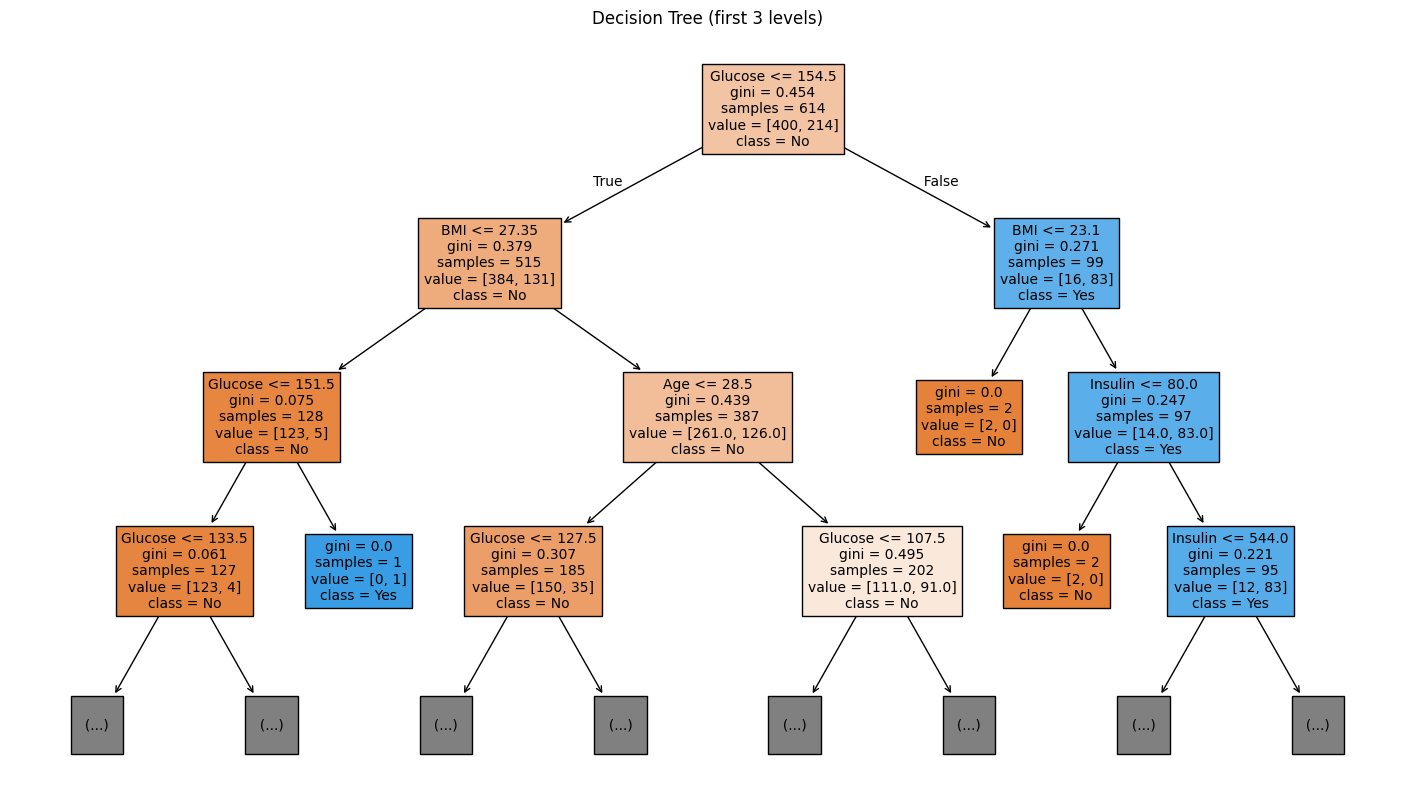

In [ ]:
plt.figure(figsize=(18,10))
plot_tree(dt, feature_names=X.columns, class_names=['No','Yes'], filled=True, max_depth=3, fontsize=10)
plt.title("Decision Tree (first 3 levels)")
plt.show()


In [ ]:
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [3,4,5,6,8,10, None],
    'min_samples_split': [2,4,6,8,10],
    'min_samples_leaf': [1,2,3,4,5]
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)
best_dt = grid.best_estimator_

# Evaluate best
y_pred_b = best_dt.predict(X_test)
y_proba_b = best_dt.predict_proba(X_test)[:,1]
print("Test Accuracy (best model):", accuracy_score(y_test, y_pred_b))
print("Test AUC (best model):", roc_auc_score(y_test, y_proba_b))
print(classification_report(y_test, y_pred_b))


Fitting 5 folds for each of 350 candidates, totalling 1750 fits
Best params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV AUC: 0.7905550941306755
Test Accuracy (best model): 0.6948051948051948
Test AUC (best model): 0.7723148148148148
              precision    recall  f1-score   support

           0       0.70      0.92      0.80       100
           1       0.65      0.28      0.39        54

    accuracy                           0.69       154
   macro avg       0.68      0.60      0.59       154
weighted avg       0.68      0.69      0.65       154



Glucose                     0.695390
BMI                         0.257349
Pregnancies                 0.032141
DiabetesPedigreeFunction    0.015120
SkinThickness               0.000000
BloodPressure               0.000000
Insulin                     0.000000
Age                         0.000000
dtype: float64


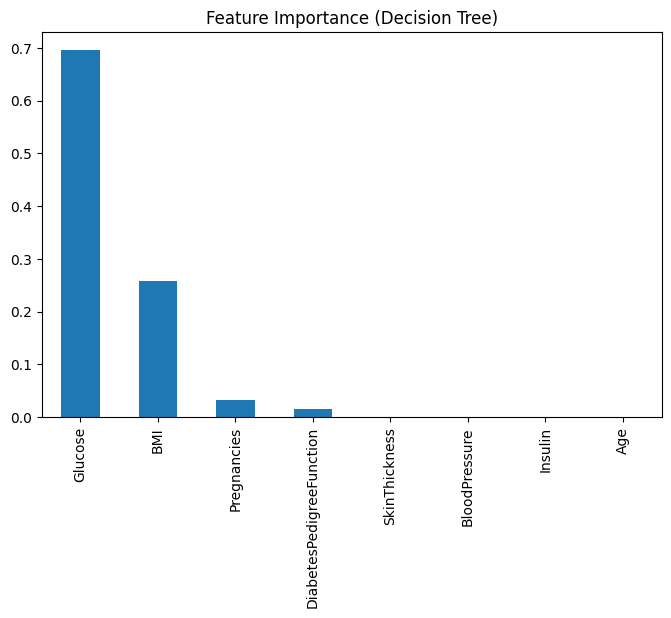

In [ ]:
fi = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)
print(fi)
plt.figure(figsize=(8,5))
fi.plot(kind='bar')
plt.title("Feature Importance (Decision Tree)")
plt.show()


In [ ]:
cv_scores = cross_val_score(best_dt, X, y, cv=5, scoring='accuracy')
print("CV Accuracy scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


CV Accuracy scores: [0.72077922 0.72077922 0.74025974 0.75163399 0.73856209]
Mean CV Accuracy: 0.7344028520499108


In [ ]:
# Save model + scaler (if used)
joblib.dump(best_dt, 'decision_tree_diabetes.joblib')
joblib.dump(scaler, 'scaler.joblib')  # optional if you used scaled features elsewhere

# Download files to local
files.download('decision_tree_diabetes.joblib')  # Colab will prompt download
files.download('scaler.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def predict_patient(sample_dict, model=best_dt):
    """
    sample_dict: dict with same keys as X.columns
    returns: predicted class and probability
    """
    row = pd.DataFrame([sample_dict])[X.columns]  # ensure order
    # if you used scaling in production, apply scaler.transform(row)
    proba = model.predict_proba(row)[0,1]
    pred = int(model.predict(row)[0])
    return {'prediction': pred, 'probability_of_diabetes': float(proba)}

# Example usage:
example = {
    'Pregnancies': 2, 'Glucose': 120, 'BloodPressure': 70,
    'SkinThickness': 20, 'Insulin': 79, 'BMI': 28.5,
    'DiabetesPedigreeFunction': 0.5, 'Age': 33
}
print(predict_patient(example))


{'prediction': 0, 'probability_of_diabetes': 0.39590443686006827}
